<a href="https://colab.research.google.com/github/sateesh12/tf/blob/main/vgg16_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['figure.figsize'] = (12,9)
SEED_VALUE = 42

In [ ]:
def download_and_unzip(url, save_name):
    #url = url
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
    try:
        with zipfile.ZipFile(save_name) as z:
            z.extractall("./")
            print('Extracted all')
    except:
        print('Invalid data')

download_and_unzip('https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1',
    'dataset_balls.zip')

In [ ]:
from keras.api._v2.keras import datasets
@dataclass (frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:    int = 224
    IMG_WIDTH:     int  = 224
    CHANNELS:        int  = 3
    BATCH_SIZE:     int  = 32
    DATA_ROOT_TRAIN: str='./dataset_balls/train'
    DATA_ROOT_VALID: str='./dataset_balls/valid'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 32
    EPOCSHS:     int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR: str = './saved_models_balls'


In [17]:
# Load an existing VGG16  model using Keras.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
'''
print('Load the model with random weights')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights=None)
vgg16_conv_base.trainable = True
print('All kernel weights are trainable')
'''
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
vgg16_conv_base.trainable = False

print(vgg16_conv_base.summary())

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [18]:
# Add classifictaion layer, the above CNN extracted the features.
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
vgg16_model = keras.Model(inputs, outputs)
print(vgg16_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

In [ ]:
# Split into training and validation set
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                                                        batch_size=TrainingConfig.BATCH_SIZE,
                                                                        seed = SEED_VALUE,
                                                                        label_mode='categorical',
                                                                        image_size = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT))
valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                                                        batch_size=TrainingConfig.BATCH_SIZE,
                                                                        seed = SEED_VALUE,
                                                                        label_mode='categorical',
                                                                        image_size = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT))

In [19]:
from keras.engine.training import optimizer
# Compile and train the model of vgg-16
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                                                       loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                       metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                                                                save_weights_only=False,
                                                                                                monitor='val_accuracy',
                                                                                                mode='max',
                                                                                                save_best_only=True)
trainig_results = vgg16_model.fit(train_dataset,
                                                validation_data=valid_dataset,
                                                epochs=TrainingConfig.EPOCSHS,
                                                workers=4,
                                                use_multiprocessing=True,
                                                callbacks=model_checkpoint_callback)

Epoch 1/51
35/36 [============================>.] - ETA: 0s - loss: 3.0300 - accuracy: 0.7920

36/36 [==============================] - 10s 244ms/step - loss: 3.0165 - accuracy: 0.7929 - val_loss: 0.6073 - val_accuracy: 0.9450
Epoch 2/51
35/36 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9911

36/36 [==============================] - 8s 232ms/step - loss: 0.0690 - accuracy: 0.9911 - val_loss: 0.4711 - val_accuracy: 0.9500
Epoch 3/51
35/36 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9973

36/36 [==============================] - 9s 231ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.3141 - val_accuracy: 0.9600
Epoch 4/51
36/36 [==============================] - 5s 147ms/step - loss: 1.8289e-04 - accuracy: 1.0000 - val_loss: 0.3522 - val_accuracy: 0.9600
Epoch 5/51
36/36 [==============================] - 5s 147ms/step - loss: 1.9318e-05 - accuracy: 1.0000 - val_loss: 0.3521 - val_accuracy: 0.9600
Epoch 6/51
36/36 [==============================] - 5s 147ms/step - loss: 1.3943e-05 - accuracy: 1.0000 - val_loss: 0.3521 - val_accuracy: 0.9600
Epoch 7/51
36/36 [==============================] - 6s 158ms/step - loss: 1.0931e-05 - accuracy: 1.0000 - val_loss: 0.3523 - val_accuracy: 0.9600
Epoch 8/51
36/36 [==============================] - 6s 148ms/step - loss: 8.9293e-06 - accuracy: 1.0000 - val_loss: 0.3522 - val_accuracy: 0.9600
Epoch 9/51
36/36 [==============================] - 6s 148ms/step - loss: 7.4926e-06 - accuracy: 1.0000 - val_loss: 0.3523 - val_accuracy: 

36/36 [==============================] - 9s 243ms/step - loss: 3.2150e-06 - accuracy: 1.0000 - val_loss: 0.3521 - val_accuracy: 0.9650
Epoch 17/51
36/36 [==============================] - 6s 151ms/step - loss: 2.9398e-06 - accuracy: 1.0000 - val_loss: 0.3521 - val_accuracy: 0.9650
Epoch 18/51
36/36 [==============================] - 6s 155ms/step - loss: 2.6985e-06 - accuracy: 1.0000 - val_loss: 0.3520 - val_accuracy: 0.9650
Epoch 19/51
36/36 [==============================] - 6s 152ms/step - loss: 2.4954e-06 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.9650
Epoch 20/51
36/36 [==============================] - 6s 155ms/step - loss: 2.3132e-06 - accuracy: 1.0000 - val_loss: 0.3520 - val_accuracy: 0.9650
Epoch 21/51
36/36 [==============================] - 6s 152ms/step - loss: 2.1497e-06 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.9650
Epoch 22/51
36/36 [==============================] - 6s 153ms/step - loss: 2.0059e-06 - accuracy: 1.0000 - val_loss: 0.3519 - val_

In [20]:
# Standard plotting function, should start to make a module of this !
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCSHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

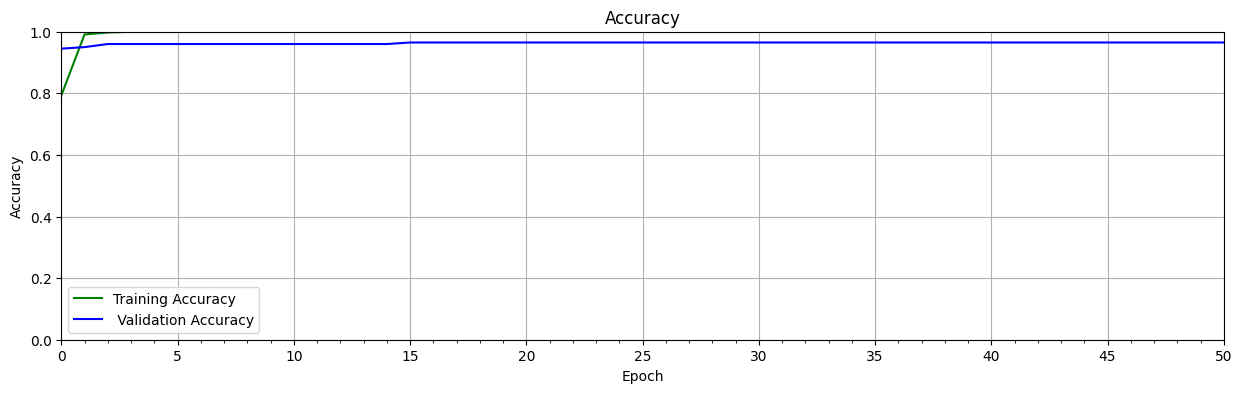

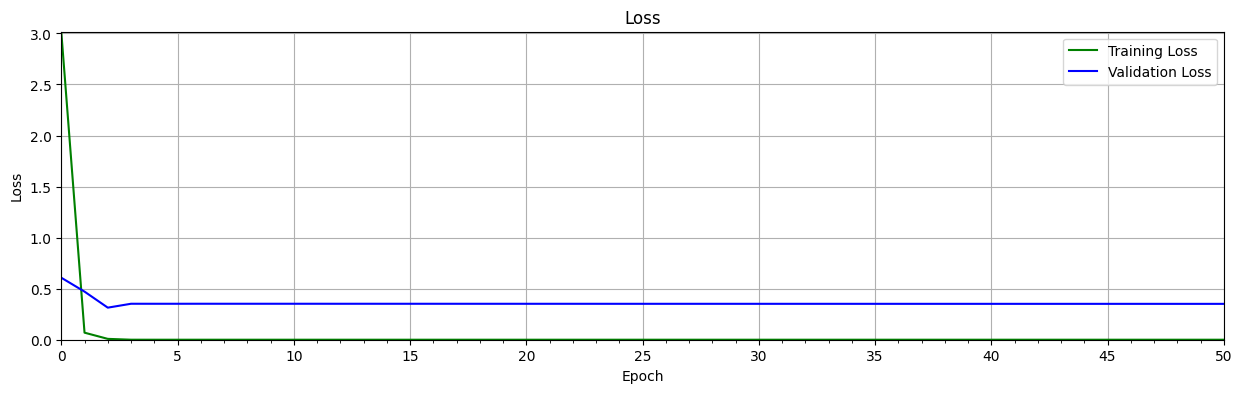

In [21]:
train_loss = trainig_results.history['loss']
train_acc  = trainig_results.history['accuracy']
valid_loss = trainig_results.history['val_loss']
valid_acc  = trainig_results.history['val_accuracy']

max_loss = max(max(train_loss), max(valid_loss))
plot_results([train_acc, valid_acc], ylabel = 'Accuracy',
                ylim=[0.0, 1.0],
                metric_name = ["Training Accuracy"," Validation Accuracy"],
                color=["g","b"])

plot_results([train_loss, valid_loss], ylabel = 'Loss',
                ylim=[0.0, max_loss],
                metric_name = ["Training Loss", "Validation Loss"],
                color=["g","b"])



In [22]:
# Evalute with test data set and print accuracy
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

7/7 [==============================] - 1s 113ms/step - loss: 0.3521 - accuracy: 0.9650
Model evaluation accuracy: 96.500
